We will start by downloading IMDB data

In [1]:
import os
import random
import spacy
import string
import pickle as pkl
from collections import Counter
import numpy as np
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import nltk


In [7]:
#Download and preprocess data into the right format

def read_files_into_list(directory):
    '''Read text files from the directory into a list'''
    
    files = os.listdir(directory)
    list_of_files = []
    
    for file in files:
        #print(file)
        with open(directory+file, 'r') as content_file:
            content = content_file.read()
            list_of_files.append(content) 
    return list_of_files

def create_model_set(positive_reviews_list, negative_reviews_list):
    '''Create shuffled list of targets and inputs'''
    #Add target variable 
    pos = [1]*len(positive_reviews_list)
    neg = [0]*len(negative_reviews_list)

    #Create lists of inputs and targets
    inputs = negative_reviews_list+positive_reviews_list
    targets = neg+pos

    #Shuffle the data
    random.seed(5)
    data_ind = list(range(0,len(inputs)))
    random.shuffle(data_ind)
    
    shuffled_inputs = [inputs[i] for i in data_ind]
    shuffled_targets = [targets[i] for i in data_ind]
    
    return shuffled_inputs, shuffled_targets


train_negative_reviews_list = read_files_into_list('../train_data.nosync/neg/')
train_positive_reviews_list = read_files_into_list('../train_data.nosync/pos/')

all_train_data, all_train_targets = create_model_set(train_positive_reviews_list, 
                                  train_negative_reviews_list)

test_negative_reviews_list = read_files_into_list('../test_data.nosync/neg/')
test_positive_reviews_list = read_files_into_list('../test_data.nosync/pos/')

all_test_data, all_test_targets = create_model_set(test_positive_reviews_list, 
                                  test_negative_reviews_list)


In [12]:
# Split train data into actual train and validation sets

train_split = 20000
train_data = all_train_data[:train_split]
train_targets = all_train_targets[:train_split]

val_data = all_train_data[train_split:]
val_targets = all_train_targets[train_split:]

test_data = all_test_data
test_targets = all_test_targets

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## Tokenization

In [15]:
# # Tokenization function using Spacy
# Credit to Ilya Kulikov

from tqdm import tqdm_notebook
nltk.download('stopwords')

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def lower_case(parsed):
    return [token.lower() for token in parsed]

def remove_punct(parsed):
    return [token for token in parsed if (token not in punctuations)]

def remove_br(parsed):
    #Remove <br>
    return [token.replace('<br/>','') for token in parsed]


def remove_stop_words(parsed):
    stop = set(nltk.corpus.stopwords.words('english'))
    return [token for token in parsed if (token not in stop)]

def tokenize_dataset(dataset, lower=False, punct=False, br=False, stop_words=False, ngram=1, mixed=False):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []

    for sample in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], 
                                               batch_size=512, n_threads=1)): 
        
        sample = [token.text for token in sample]
        
        if lower:
            sample = lower_case(sample)
        if punct:
            sample = remove_punct(sample)
        if br:
            sample = remove_br(sample)
        if stop_words:
            sample = remove_stop_words(sample)
        
        if ngram>1:
            if mixed: #N-gram + unigram
                sample = sample + list(nltk.ngrams(sample,ngram))
            else: #N-gram
                sample = list(nltk.ngrams(sample,ngram))
            
        token_dataset.append(sample)
        all_tokens += sample

    return token_dataset, all_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ksenia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def tokenize_full(val_data, test_data,
                  train_data, lower_case=False, punct=False, br=False, stop_words=False, ngram=1, mixed=False):
    
    # val set tokens
    print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset(val_data, lower=lower_case, punct=punct, 
                                          br=br, stop_words=stop_words, ngram=ngram, mixed=mixed)
    #pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

    # test set tokens
    print ("Tokenizing test data")
    test_data_tokens, _ = tokenize_dataset(test_data, lower=lower_case, punct=punct, 
                                          br=br, stop_words=stop_words, ngram=ngram, mixed=mixed)
    #pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

    # train set tokens
    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset(train_data, lower=lower_case, punct=punct, 
                                          br=br, stop_words=stop_words, ngram=ngram, mixed=mixed)
    #pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
    #pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))
    
    return val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens

## Vocabulary building

In [17]:
#Try 10,000 most common tokens

def build_vocab(all_tokens, max_vocab_size = 10000):
    
    # save index 1 for unk and 0 for pad
    PAD_IDX = 0
    UNK_IDX = 1
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size)) #* unzips the tuples
    id2token = list(vocab) #list of words
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) # dictionary of words and indices 
    id2token = ['<pad>', '<unk>'] + id2token #add pad and unknown to the beginning
    token2id['<pad>'] = PAD_IDX  #add pad symbol to the dictionary
    token2id['<unk>'] = UNK_IDX  #add unkown symbol to the dictionary
    return token2id, id2token

In [18]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    PAD_IDX = 0
    UNK_IDX = 1
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens] #tokenizes 10k words
        indices_data.append(index_list) #list of lists: indices of tokens for each sentence
    return indices_data


Now we are going to create PyTorch DataLoader 

In [19]:
MAX_SENTENCE_LENGTH = 200

class imdb_Dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list): #initialize target and input
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        tokens = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [tokens, len(tokens), label]

def imdb_collate_func(batch): #padding so all data have same length
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    MAX_SENTENCE_LENGTH = 200 #80/90% of document
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2]) #list of labels
        length_list.append(datum[1]) #length of text
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


def data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32):


    train_dataset = imdb_Dataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True) #shuffle train

    val_dataset = imdb_Dataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True) #shuffle val

    test_dataset = imdb_Dataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False) #don't shuffle test
    
    return train_loader, val_loader, test_loader


Here we will define Bag-of-Words model in PyTorch

In [20]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float() #make same shape as out
     
        # return logits
        out = self.linear(out.float())
        return out


In [70]:
# Function for testing the model
def test_model(loader, model, output_correct=False):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    correct_ind = []
    
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()

        #Find correct and incorrect
        if output_correct:
            pred = predicted.view(predicted.numel()).numpy()
            labs = label_batch.numpy()
            ind_correct = np.equal(pred,labs)
            correct_ind.extend(ind_correct)
    
    if output_correct:
        corrects = [i for i, x in enumerate(correct_ind) if not x][0:3]
        incorrect = [i for i, x in enumerate(correct_ind) if x][0:3]

        print('3 correct prediction indices: ', corrects)
        print('3 incorrect prediction indices: ', incorrect)
        
    return (100 * correct / total)

def calculate_loss(loader, model, criterion):
    
    model.eval()
    loss_hist = []
    for data, lengths, labels in loader:
        y_hat = model(data, lengths)
        loss = criterion(y_hat, labels)
        loss_hist.append(loss.item())
    average_loss = np.mean(loss_hist)
    return average_loss


def run_training(train_loader, val_loader, emb_dim=100, opt = 'Adam', learning_rate = 0.01,
                            annealing_learning_rate = False,  num_epochs = 10, reg=0):


    model = BagOfWords(len(id2token), emb_dim)

    # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    if opt =='Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        
    if annealing_learning_rate:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    train_acc_hist = []
    val_acc_hist = []
    train_loss_hist = []
    val_loss_hist = []
    train_loss_epoch = []

    for epoch in range(num_epochs):
        
        print('Epoch: ', epoch)

        batch_train_loss = 0

        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train() #set training mode
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad() #zero our gradients
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch) #calculate loss
            #train_loss.append(loss)
            batch_train_loss += loss #sum of average losses
            loss.backward() #backpropagate
            optimizer.step() #update weights
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                #print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           #epoch+1, num_epochs, i+1, len(train_loader), val_acc))

                val_loss = calculate_loss(val_loader, model, criterion)
                val_loss_hist.append(val_loss)

                train_loss = calculate_loss(train_loader, model, criterion)
                train_loss_hist.append(train_loss)

                #Save performance for plotting
                val_acc_hist.append(val_acc)
                train_acc = test_model(train_loader, model)
                train_acc_hist.append(train_acc)
                
                if annealing_learning_rate: #anneal learning rate
                    scheduler.step()

        train_loss_epoch.append(batch_train_loss/(i+1)) #average train loss per epoch num batches
        
    _ = test_model(val_loader, model, output_correct=True)
    print('Val Acc: ', _)
        
    return train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist
    


In [22]:
def make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist):
    
    #Accuracy
    plt.plot(train_acc_hist, label='Train Set Accuracy')
    plt.plot(val_acc_hist, label='Val Set Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.title('Training Curves')
    plt.legend()
    plt.show()
    
    #Loss
    plt.plot(train_loss_hist)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss per Iteration')
    plt.show()
    
    plt.plot(val_loss_hist)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Validation Loss per Iteration')
    plt.show()
    
    print ("Val Acc Last Epoch {}".format(val_acc_hist[-1]))
    print( "Max Val Acc {}".format(max(val_acc_hist)))
    print( "Avg Val Acc {}".format(np.average(val_acc_hist)))
    

### Tokenization experiments

#### No tokenizing

In [120]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(train_data)

train_data_indices = token2index_dataset(train_data)
val_data_indices = token2index_dataset(val_data)
test_data_indices = token2index_dataset(test_data)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [121]:
#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [0, 1, 3]
3 incorrect prediction indices:  [2, 5, 6]
Val Acc:  49.78


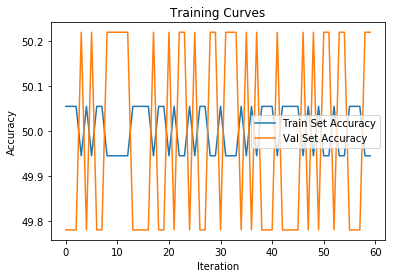

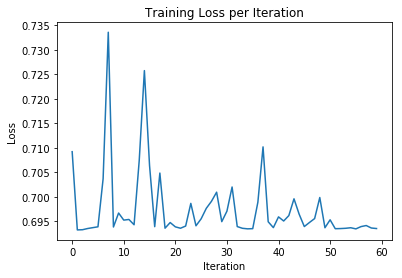

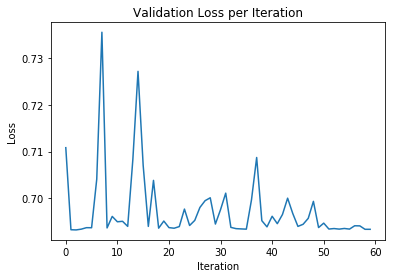

Val Acc Last Epoch 50.22
Max Val Acc 50.22
Avg Val Acc 49.98533333333333


In [122]:
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

#### Tokenizing

In [24]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=False, punct=False, br=False, stop_words=False)

Tokenizing val data



Tokenizing test data



Tokenizing train data


In [25]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [26]:
#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [5, 10, 12]
3 incorrect prediction indices:  [0, 1, 2]


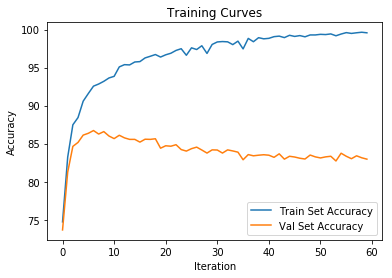

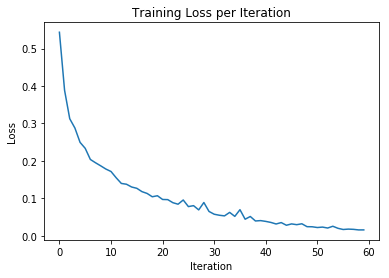

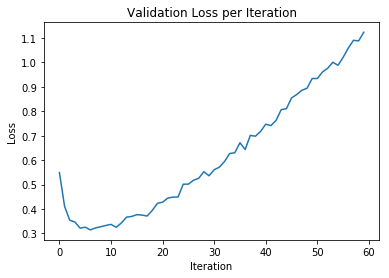

Val Acc Last Epoch 82.96
Max Val Acc 86.72
Avg Val Acc 84.04766666666667


In [27]:
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

#### Lowercase

In [31]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=False, br=False, stop_words=False)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [0, 6, 10]
3 incorrect prediction indices:  [1, 2, 3]


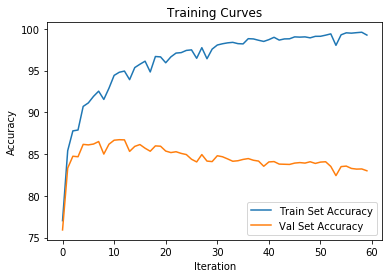

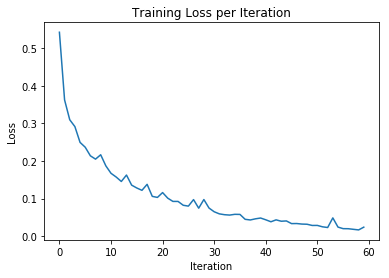

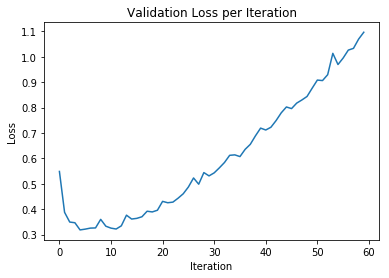

Val Acc Last Epoch 83.0
Max Val Acc 86.72
Avg Val Acc 84.48033333333335


In [32]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)


#### Remove punctuation

In [42]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=False, stop_words=False)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [6, 13, 18]
3 incorrect prediction indices:  [0, 1, 2]


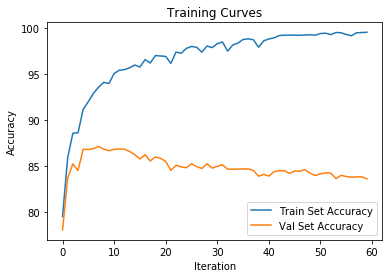

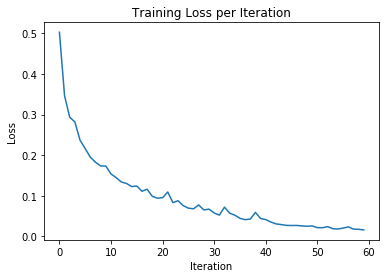

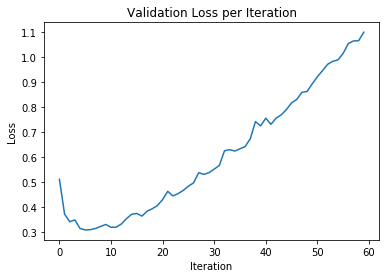

Val Acc Last Epoch 83.62
Max Val Acc 87.14
Avg Val Acc 84.89733333333334


In [43]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)


#### Remove br sign

In [44]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=False)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [2, 6, 17]
3 incorrect prediction indices:  [0, 1, 3]


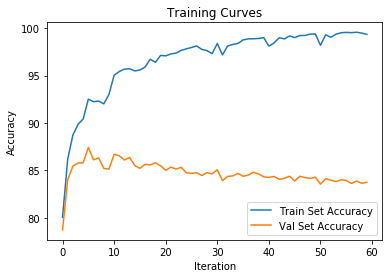

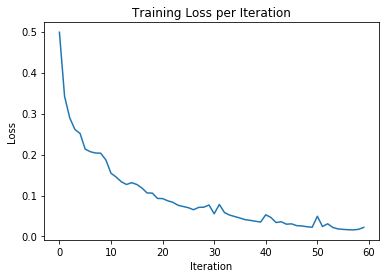

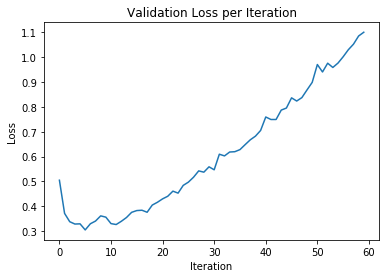

Val Acc Last Epoch 83.74
Max Val Acc 87.42
Avg Val Acc 84.72


In [45]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

#### Remove stop words

In [68]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=True)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [4, 13, 22]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  85.24


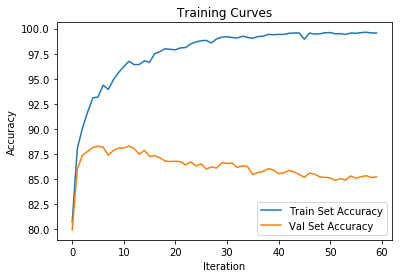

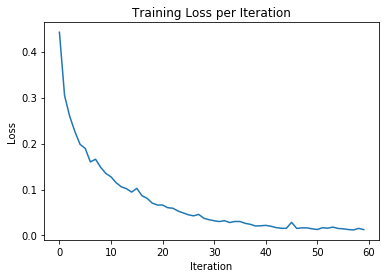

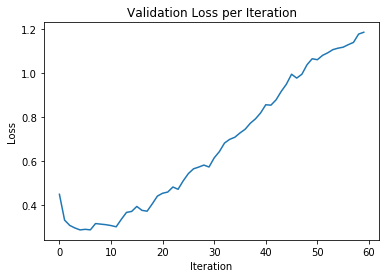

Val Acc Last Epoch 85.22
Max Val Acc 88.3
Avg Val Acc 86.25966666666666


In [72]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## N-Gram Tuning

### Bi-gram

In [91]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=True, ngram=2)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [6, 7, 11]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  78.16


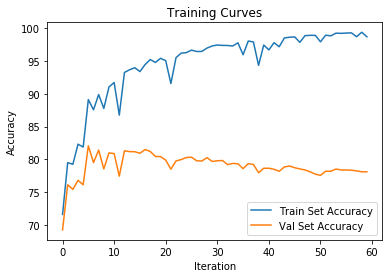

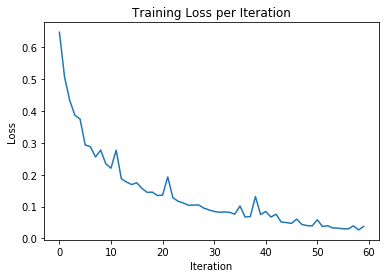

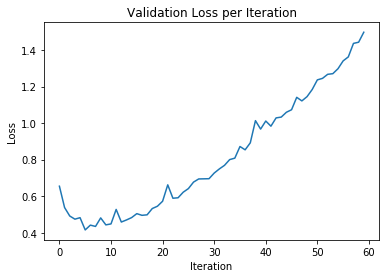

Val Acc Last Epoch 78.1
Max Val Acc 82.06
Avg Val Acc 78.97700000000002


In [92]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

### Tri-Gram

In [93]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=True, ngram=3)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [0, 2, 3]
3 incorrect prediction indices:  [1, 5, 6]
Val Acc:  55.0


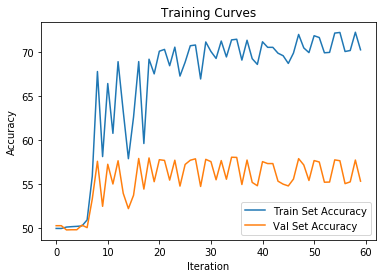

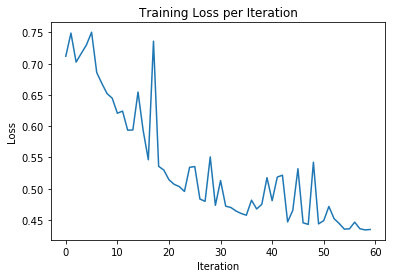

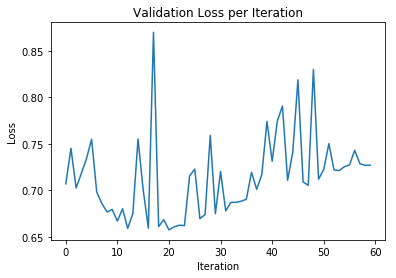

Val Acc Last Epoch 55.3
Max Val Acc 58.02
Avg Val Acc 55.47966666666666


In [97]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

### 4-Gram

In [98]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=True, ngram=4)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [0, 2, 3]
3 incorrect prediction indices:  [1, 6, 7]
Val Acc:  57.26


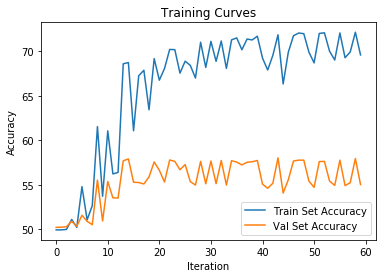

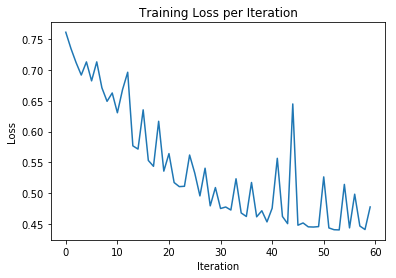

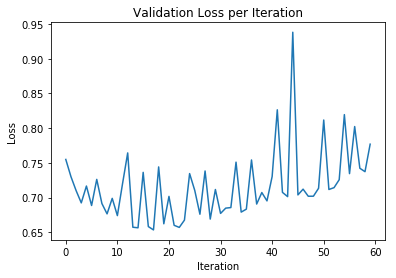

Val Acc Last Epoch 55.04
Max Val Acc 58.04
Avg Val Acc 55.443666666666665


In [99]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

### Bi-gram + unigram

In [100]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=True, ngram=2, mixed=True)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [1, 16, 22]
3 incorrect prediction indices:  [0, 2, 3]
Val Acc:  84.44


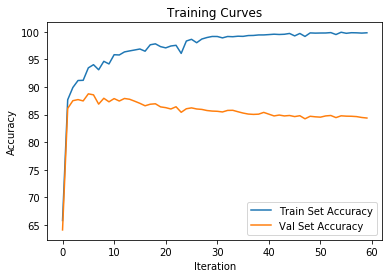

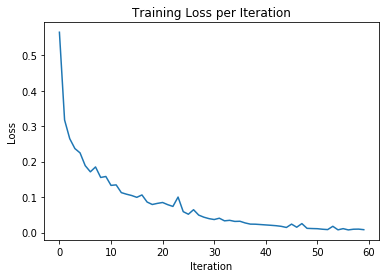

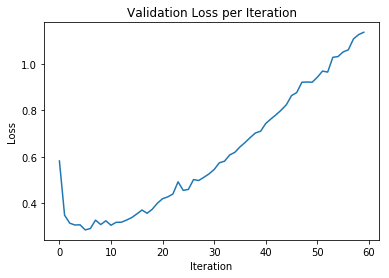

Val Acc Last Epoch 84.38
Max Val Acc 88.76
Avg Val Acc 85.53766666666665


In [101]:
#Tokenize
#Build vocabulary
token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## Vocabulary Size Tuning

In [102]:
val_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=True, ngram=2, mixed=True)

Tokenizing val data



Tokenizing test data



Tokenizing train data


Vocabulary size:  5000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [4, 16, 26]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  85.28


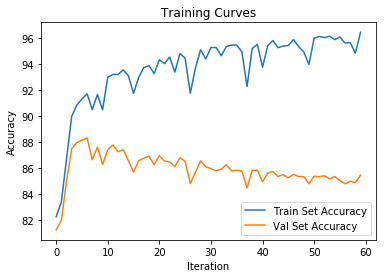

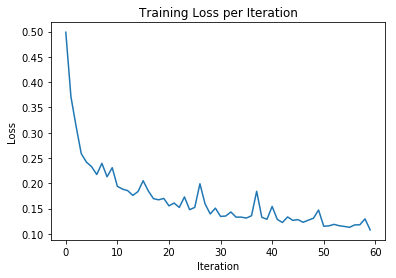

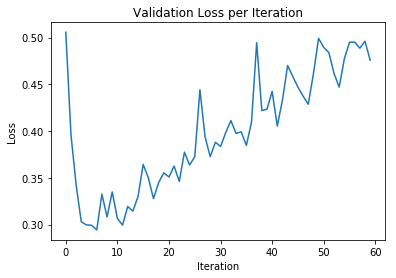

Val Acc Last Epoch 85.46
Max Val Acc 88.32
Avg Val Acc 85.91166666666665
Vocabulary size:  10000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [6, 12, 29]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  84.36


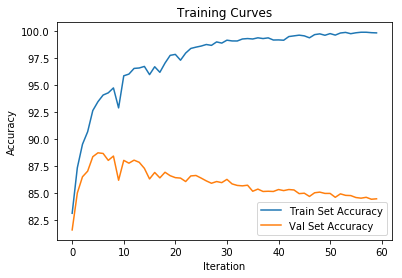

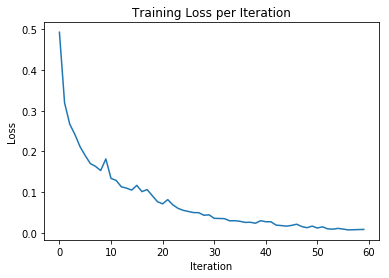

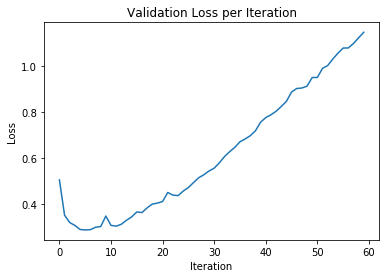

Val Acc Last Epoch 84.44
Max Val Acc 88.7
Avg Val Acc 85.90566666666665
Vocabulary size:  50000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [0, 2, 26]
3 incorrect prediction indices:  [1, 3, 4]
Val Acc:  88.6


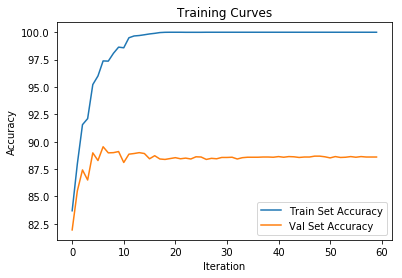

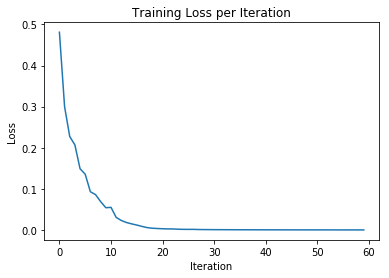

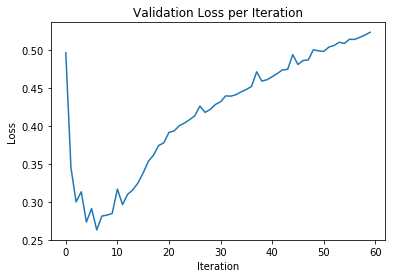

Val Acc Last Epoch 88.6
Max Val Acc 89.54
Avg Val Acc 88.40400000000002
Vocabulary size:  100000
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [6, 8, 32]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.92


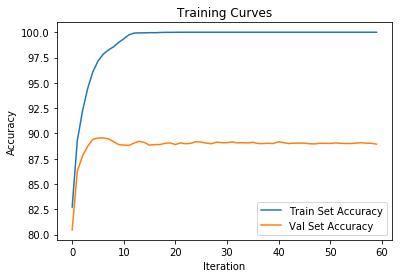

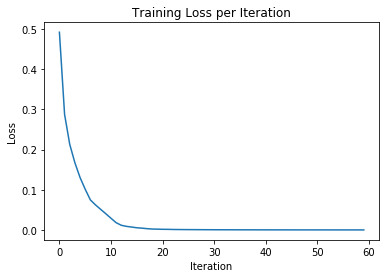

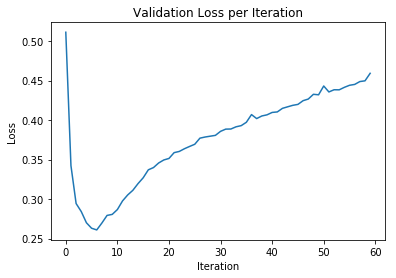

Val Acc Last Epoch 88.94
Max Val Acc 89.56
Avg Val Acc 88.845


In [103]:
#Tokenize
#Build vocabulary

vocabulary_sizes = [5000, 10000, 50000, 100000]

for i in vocabulary_sizes:
    
    print('Vocabulary size: ', i)

    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = i)

    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)

    #Make loaders
    train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                    val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

    #Run training
    train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                                  val_loader)
    #Plot results
    make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## Embedding size

Embedding size:  50
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [0, 15, 28]
3 incorrect prediction indices:  [1, 2, 3]
Val Acc:  88.32


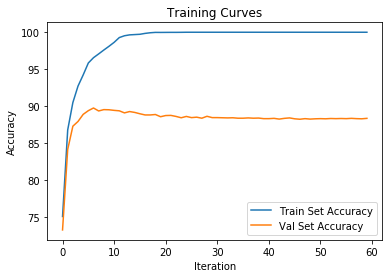

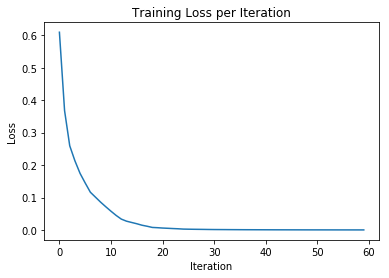

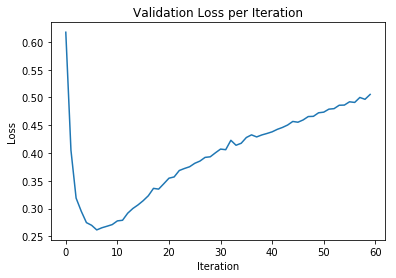

Val Acc Last Epoch 88.36
Max Val Acc 89.76
Avg Val Acc 88.26166666666664
Embedding size:  100
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [0, 14, 22]
3 incorrect prediction indices:  [1, 2, 3]
Val Acc:  88.48


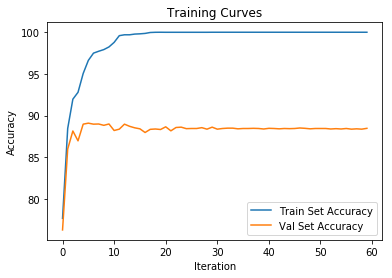

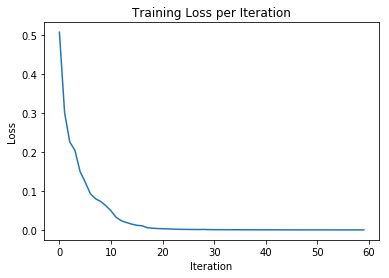

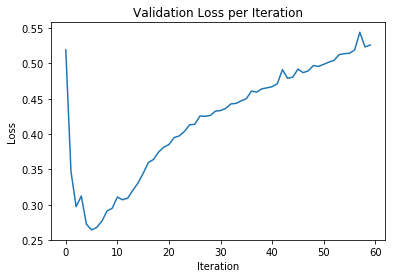

Val Acc Last Epoch 88.48
Max Val Acc 89.1
Avg Val Acc 88.234
Embedding size:  200
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [3, 11, 29]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.04


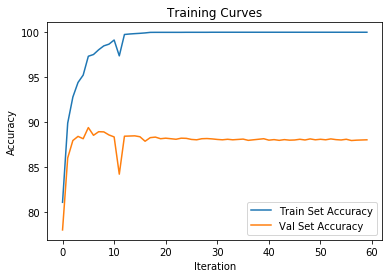

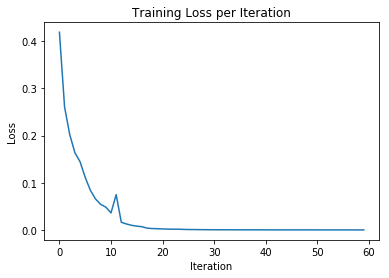

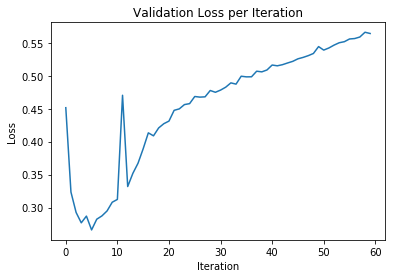

Val Acc Last Epoch 88.04
Max Val Acc 89.4
Avg Val Acc 87.91833333333334
Embedding size:  500
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [2, 7, 11]
3 incorrect prediction indices:  [0, 1, 3]
Val Acc:  88.26


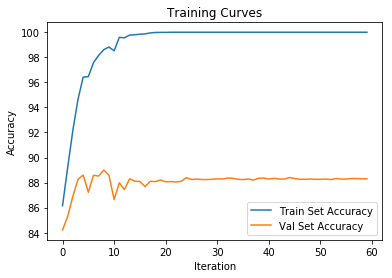

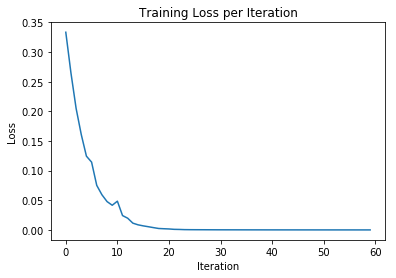

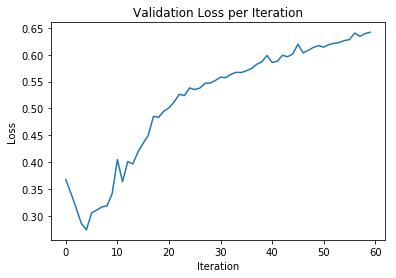

Val Acc Last Epoch 88.3
Max Val Acc 89.0
Avg Val Acc 88.076


In [104]:
#Tokenize
#Build vocabulary

embedding_dims = [50, 100, 200, 500]

for i in embedding_dims:
    
    print('Embedding size: ', i)

    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 50000)

    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)

    #Make loaders
    train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                    val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

    #Run training
    train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                                  val_loader,
                                                                                                 emb_dim = i)
    #Plot results
    make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## Optimizer

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [2, 5, 7]
3 incorrect prediction indices:  [0, 1, 3]
Val Acc:  67.58


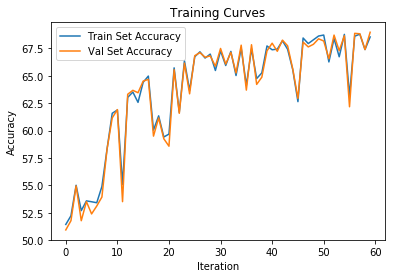

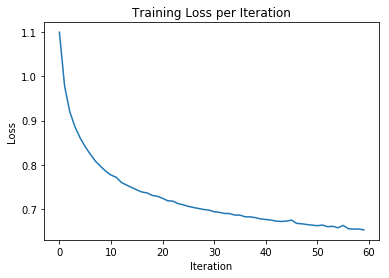

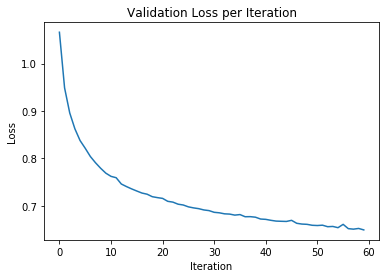

Val Acc Last Epoch 68.98
Max Val Acc 68.98
Avg Val Acc 63.57833333333334


In [105]:
#Previous code used Adam optimizer, Let's try SGD

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 50000)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)

#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader,
                                                                                             emb_dim = 50,
                                                                                             opt='SGD')
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## Learning Rate

### Learning rate variations


Learning rate:  0.001
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [5, 14, 25]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  89.06


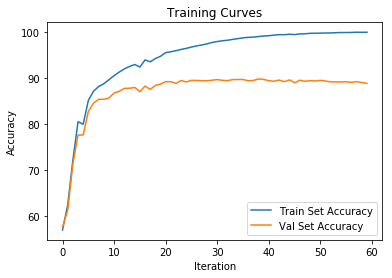

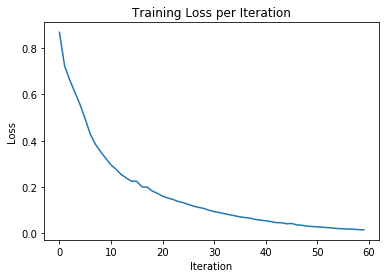

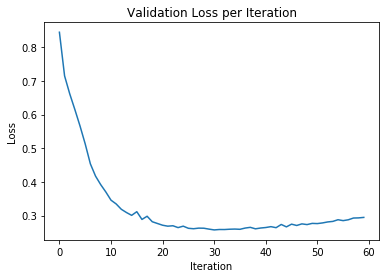

Val Acc Last Epoch 88.84
Max Val Acc 89.8
Avg Val Acc 87.01466666666668

Learning rate:  0.005
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [5, 28, 29]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.56


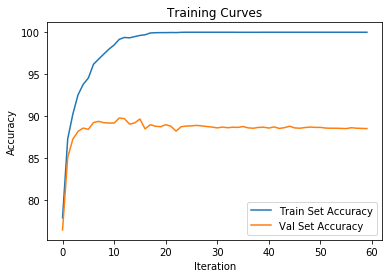

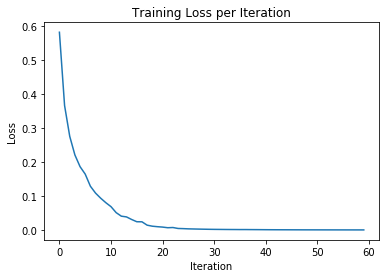

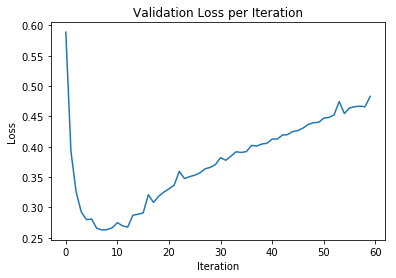

Val Acc Last Epoch 88.5
Max Val Acc 89.76
Avg Val Acc 88.45866666666669

Learning rate:  0.01
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [8, 16, 27]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.68


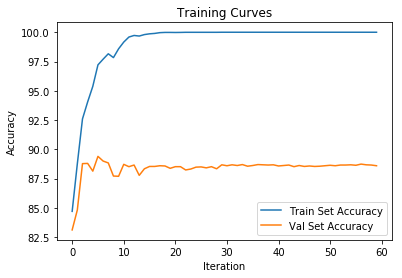

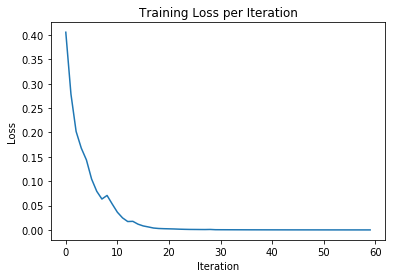

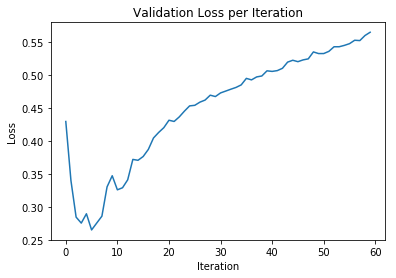

Val Acc Last Epoch 88.6
Max Val Acc 89.4
Avg Val Acc 88.40666666666668

Learning rate:  0.05
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [6, 8, 9]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  85.18


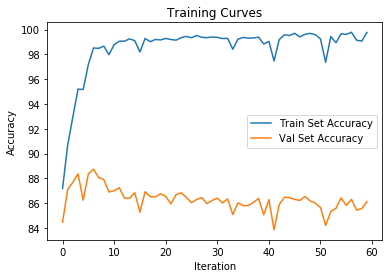

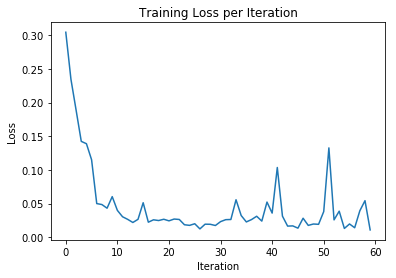

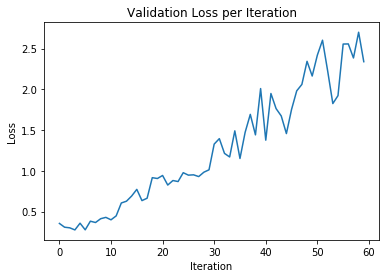

Val Acc Last Epoch 86.12
Max Val Acc 88.74
Avg Val Acc 86.31

Learning rate:  0.1
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [10, 11, 18]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  86.28


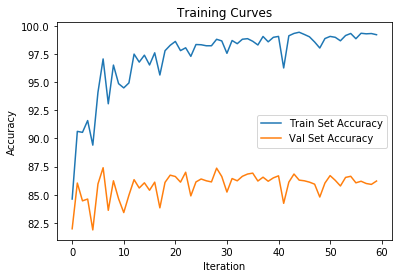

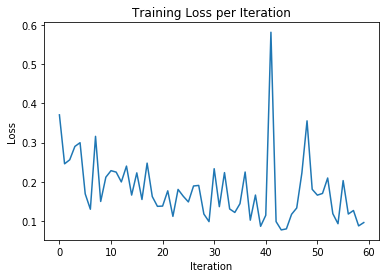

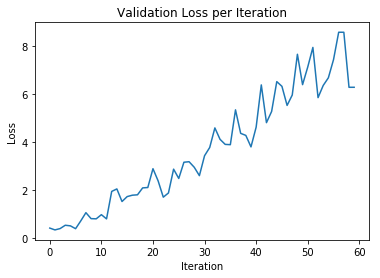

Val Acc Last Epoch 86.22
Max Val Acc 87.4
Avg Val Acc 85.84033333333333


In [106]:

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]

for i in learning_rates:
    #Run training
    print('\nLearning rate: ', i)
    train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                              val_loader,
                                                                                             emb_dim = 50,
                                                                                             opt='Adam',
                                                                                      learning_rate = i)
    #Plot results
    make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

### Annealing of learning rate

### 0.01 Start rate

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [3, 8, 19]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.84


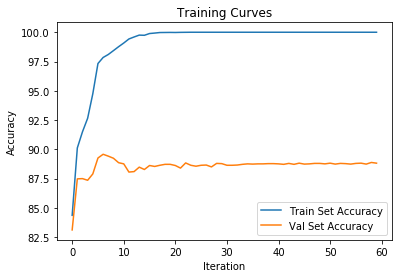

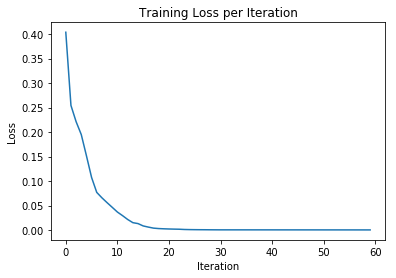

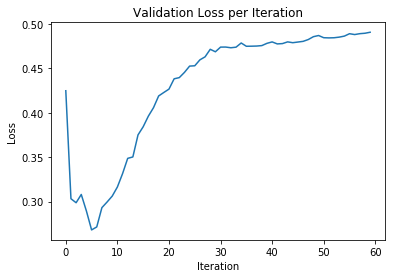

Val Acc Last Epoch 88.82
Max Val Acc 89.58
Avg Val Acc 88.56566666666666


In [107]:
#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                          val_loader,
                                                                                         emb_dim = 50,
                                                                                         opt='Adam', 
                                                                                learning_rate = 0.01,    
                                                                             annealing_learning_rate=True)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

### 0.005 start rate

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [6, 12, 20]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.82


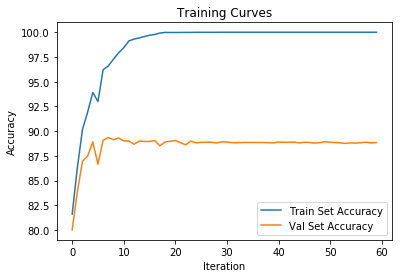

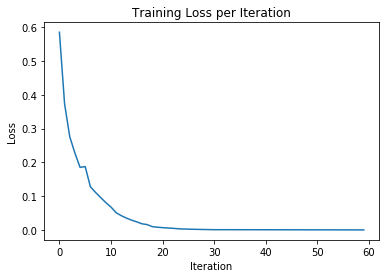

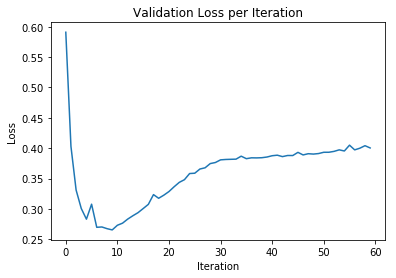

Val Acc Last Epoch 88.84
Max Val Acc 89.36
Avg Val Acc 88.56933333333335


In [108]:
#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                          val_loader,
                                                                                         emb_dim = 50,
                                                                                         opt='Adam', 
                                                                                learning_rate = 0.005,    
                                                                             annealing_learning_rate=True)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## Additional hyperparameter variations

## Number of epochs

Epoch:  0
3 correct prediction indices:  [17, 25, 31]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.54


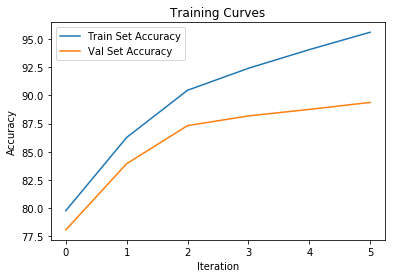

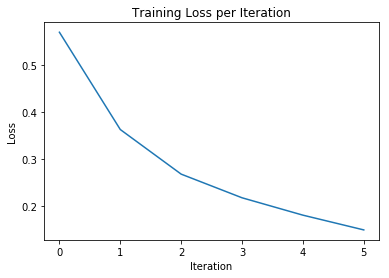

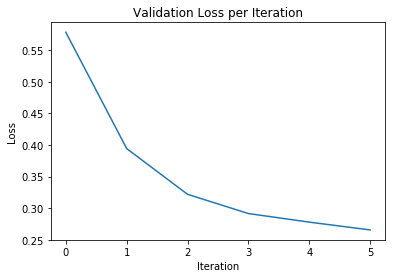

Val Acc Last Epoch 89.38
Max Val Acc 89.38
Avg Val Acc 85.94
Epoch:  0
Epoch:  1
Epoch:  2
3 correct prediction indices:  [12, 25, 37]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.86


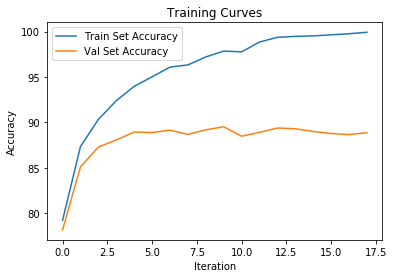

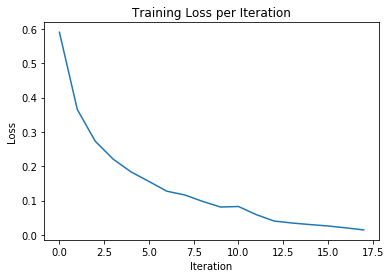

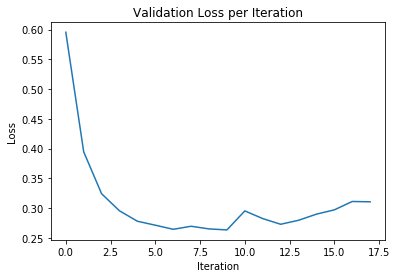

Val Acc Last Epoch 88.86
Max Val Acc 89.52
Avg Val Acc 88.01666666666668
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
3 correct prediction indices:  [4, 8, 11]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.54


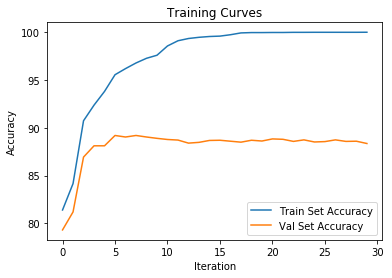

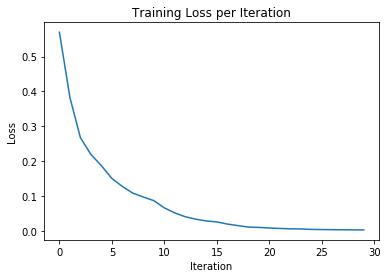

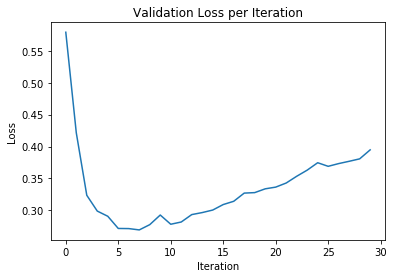

Val Acc Last Epoch 88.36
Max Val Acc 89.2
Avg Val Acc 88.05266666666667
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
3 correct prediction indices:  [5, 17, 26]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.3


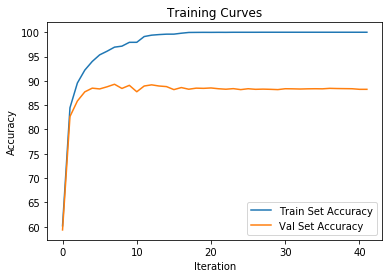

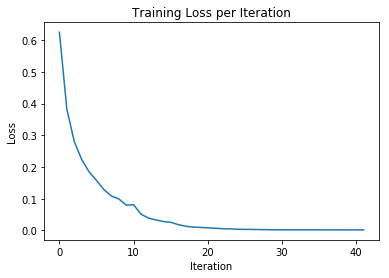

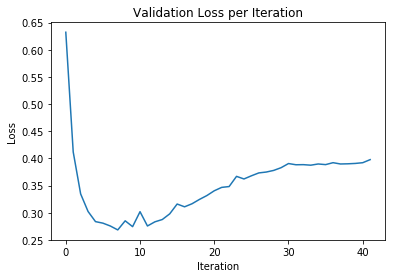

Val Acc Last Epoch 88.26
Max Val Acc 89.3
Avg Val Acc 87.55428571428573
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
3 correct prediction indices:  [2, 12, 19]
3 incorrect prediction indices:  [0, 1, 3]
Val Acc:  88.68


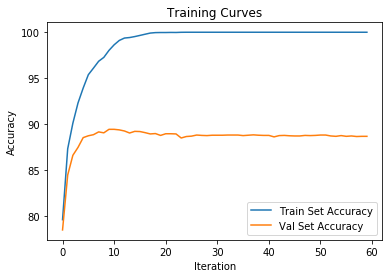

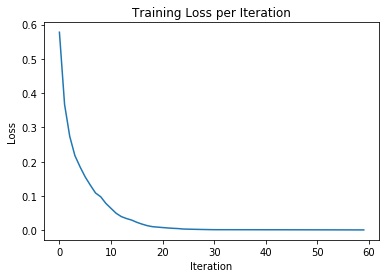

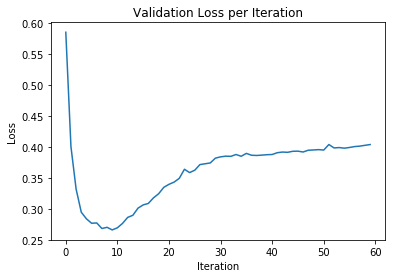

Val Acc Last Epoch 88.7
Max Val Acc 89.46
Avg Val Acc 88.56666666666666


In [109]:
num_epochs = [1, 3, 5, 7, 10]

for i in num_epochs:
    #Run training
    train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                          val_loader,
                                                                                         emb_dim = 50,
                                                                                         opt='Adam', 
                                                                                learning_rate = 0.01,    
                                                                             annealing_learning_rate=True,
                                                                             num_epochs = i)
    #Plot results
    make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## Regularization

Reg:  1e-05
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
3 correct prediction indices:  [2, 12, 17]
3 incorrect prediction indices:  [0, 1, 3]
Val Acc:  88.66


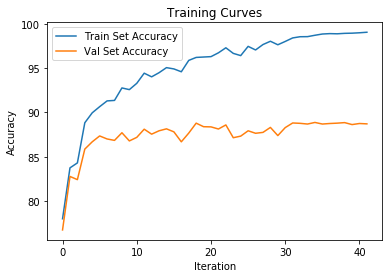

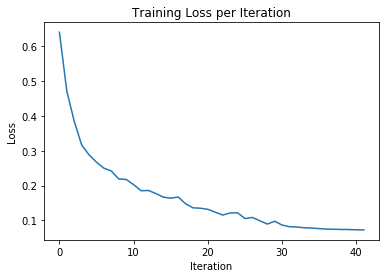

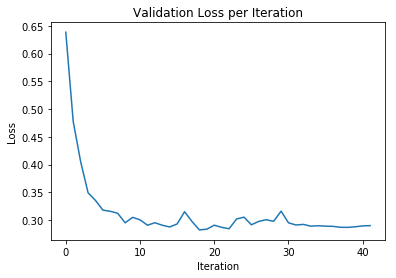

Val Acc Last Epoch 88.72
Max Val Acc 88.88
Avg Val Acc 87.43238095238095
Reg:  0.001
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
3 correct prediction indices:  [1, 4, 10]
3 incorrect prediction indices:  [0, 2, 3]
Val Acc:  81.94


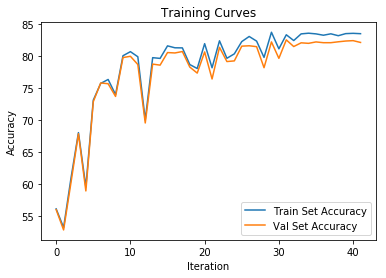

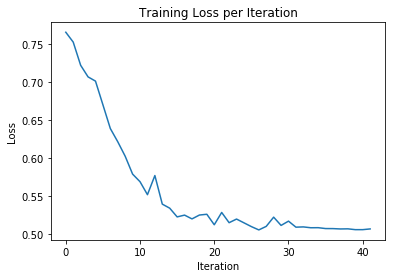

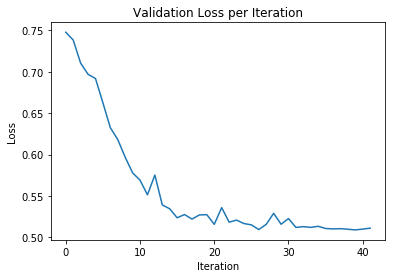

Val Acc Last Epoch 82.1
Max Val Acc 82.5
Avg Val Acc 77.16190476190475
Reg:  0.01
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
3 correct prediction indices:  [0, 1, 2]
3 incorrect prediction indices:  [5, 6, 7]
Val Acc:  50.22


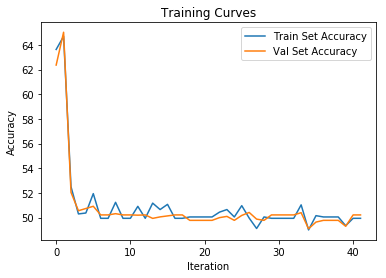

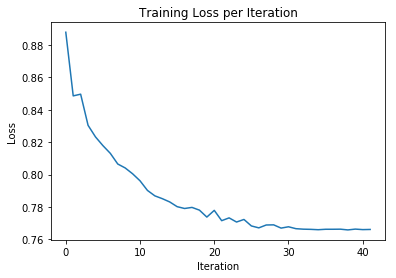

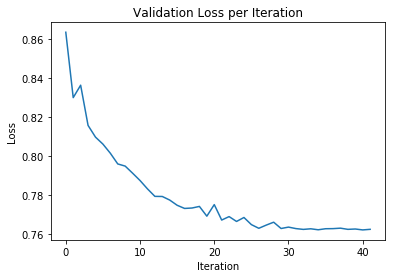

Val Acc Last Epoch 50.22
Max Val Acc 65.02
Avg Val Acc 50.766666666666666


In [110]:
regs = [1e-5, 1e-3, 1e-2]

for r in regs:
    
    print('Reg: ', r)

    #Run training
    train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                          val_loader,
                                                                                         emb_dim = 50,
                                                                                         opt='Adam', 
                                                                                learning_rate = 0.01,    
                                                                             annealing_learning_rate=True,
                                                                             num_epochs = 7,
                                                                             reg = r)
    #Plot results
    make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
3 correct prediction indices:  [3, 60, 63]
3 incorrect prediction indices:  [0, 1, 2]
Val Acc:  88.58


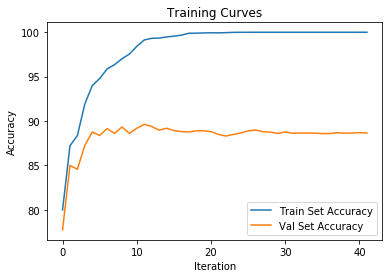

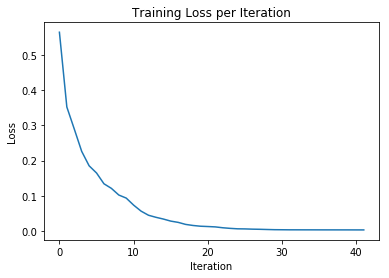

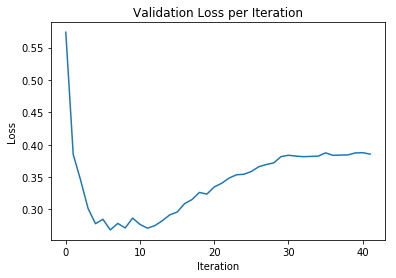

Val Acc Last Epoch 88.64
Max Val Acc 89.62
Avg Val Acc 88.29142857142855


In [111]:
#Run training
train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist = run_training(train_loader, 
                                                                                      val_loader,
                                                                                     emb_dim = 50,
                                                                                     opt='Adam', 
                                                                            learning_rate = 0.01,    
                                                                         annealing_learning_rate=True,
                                                                         num_epochs = 7,
                                                                         reg = 1e-7)
#Plot results
make_plots(train_acc_hist, val_acc_hist, train_loss_epoch, train_loss_hist, val_loss_hist)

## Final check of best model on Test Set

In [124]:
#Tokenize
al_data_tokens, test_data_tokens, train_data_tokens, all_train_tokens = tokenize_full(val_data, test_data,
                  train_data, lower_case=True, punct=True, br=True, stop_words=True, ngram=2, mixed=True)

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 50000)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

#Make loaders
train_loader, val_loader, test_loader = data_loader(train_data_indices, train_targets, val_data_indices, 
                val_targets, test_data_indices, test_targets, BATCH_SIZE = 32)


Tokenizing val data



Tokenizing test data



Tokenizing train data


In [126]:
#Set up model
model = BagOfWords(len(id2token), 50)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-7)

#Annealing learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


for epoch in range(num_epochs):

    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train() #set training mode
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad() #zero our gradients
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch) #calculate loss
        loss.backward() #backpropagate
        optimizer.step() #update weights
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

            #anneal learning rate
            scheduler.step()

Epoch: [1/7], Step: [101/625], Validation Acc: 77.56
Epoch: [1/7], Step: [201/625], Validation Acc: 83.66
Epoch: [1/7], Step: [301/625], Validation Acc: 87.12
Epoch: [1/7], Step: [401/625], Validation Acc: 88.04
Epoch: [1/7], Step: [501/625], Validation Acc: 86.24
Epoch: [1/7], Step: [601/625], Validation Acc: 89.0
Epoch: [2/7], Step: [101/625], Validation Acc: 89.18
Epoch: [2/7], Step: [201/625], Validation Acc: 89.26
Epoch: [2/7], Step: [301/625], Validation Acc: 89.4
Epoch: [2/7], Step: [401/625], Validation Acc: 88.82
Epoch: [2/7], Step: [501/625], Validation Acc: 89.62
Epoch: [2/7], Step: [601/625], Validation Acc: 89.38
Epoch: [3/7], Step: [101/625], Validation Acc: 89.16
Epoch: [3/7], Step: [201/625], Validation Acc: 89.28
Epoch: [3/7], Step: [301/625], Validation Acc: 88.86
Epoch: [3/7], Step: [401/625], Validation Acc: 89.28
Epoch: [3/7], Step: [501/625], Validation Acc: 88.74
Epoch: [3/7], Step: [601/625], Validation Acc: 88.54
Epoch: [4/7], Step: [101/625], Validation Acc: 8

In [128]:
print('Validation set accuracy: ',test_model(val_loader, model))


Validation set accuracy:  88.68


In [129]:
#3 correct and 3 incorrect
test_model(val_loader, model, output_correct=True)

3 correct prediction indices:  [12, 27, 29]
3 incorrect prediction indices:  [0, 1, 2]


88.68

### 3 Correct Predictions on validation set

In [131]:
val_data[12]

'I came home late one night and turned on the TV, to see Siskel and Ebert summarizing their picks of the week. I didn\'t hear anything about "Red Rock West", except two thumbs up and see it before it went away. It wouldn\'t stay in theaters very long because of the distributor\'s money problems and lack of promotion, but they said it deserved better.<br /><br />The next afternoon, I followed their advice. They were right, it was some of the most fun I have ever had at the movies. As some readers point out, there are a few plot holes and the last 10 minutes don\'t ever seem to end. But it\'s well worth it, for the fine craftwork that went into the first hour. It\'s the best role that I have ever seen for Nicholas Cage, but almost everybody seems perfectly cast. Dennis Hopper goes almost over the top, which gets silly but reinforces how well everything else works. The sets and the music contribute a great deal to almost every scene.<br /><br />When I rented it later for my family, it did

In [132]:
val_data[27]

'The Japanese "Run Lola Run," his is one offbeat movie which will put a smile on just about anyone\'s face. Fans of Run Lola Run, Tampopo, Go!, and Slacker will probably like this one. It does tend to follow a formula that is increasingly popular these days of separate, seemingly unrelated vignettes, all contributing the the overall story in unexpected ways. catch it if you see it, otherwise wait for the rental.'

In [133]:
val_data[29]

'This movie was terrible. The plot sucked, the acting was bad, the editing was inept and this movie makes me want to poke my eyes out. I wish I had the time I spent watching this movie back. The balloon scene was stupid, the Mormon jokes are really old, the soundtrack sucked, I saw no chemistry between the two leads, it\'s full of stereotypes, stupid local "celeb" cameo\'s..most noted was Del "I\'m going to drive as fast as I want to.." computer idiot. What is worst is that these actors had to play themselves on the spiritual side and even they screwed that up. This movie help create a long line of lackluster efforts to mainstream LDS beliefs into Hollywood. I.E. The RM, Church ball, etc. etc. I would forgo watching this movie and instead run head first into a brick wall. You will be more entertained than watching this poor excuse for a show.'

### 3 Incorrect Predictions on Validation Set

In [136]:
val_data[0]

'Scotty (Grant Cramer, who would go on to star in the great B-movie "Killer Klowns from outer space") agrees to help three middle-aged guys learn how to \'dialog\' the ladies in this bad \'80\'s comedy. Not bad as in \'80\'s lingo, which meant good. Bad as in bad. With no likable characters, including, but not limited to, a kid who\'s the freakiest looking guy since "Friday the 13th part 2"\' a girl who leads men on and then goes into hissy fits when they want to touch her, and the token fat slob, because after all what would an \'80\'s sex comedy be without a fat slob?? Well this one has two. This movie is pretty much the bottom of the barrel of \'80\'s sex comedies. And then came the sequel thus deepening said proverbial barrel.<br /><br />My Grade:D- <br /><br />Eye Candy: too numerous to count, you even see the freaky looking kid imagined with boobs at on point, think "Bachlor Party" but not as funny, and VERY disturbing.<br /><br />Where I saw it: Comcast Moviepass'

In [140]:
print('Correct label: ', val_targets[0])

Correct label:  0


In [142]:
val_data[1]

'In the 60\'s, having as the background the rehearsal and recording of "Sympathy for the Devil" in the classic album "Beggar\'s Banquet" by the revolutionary bad boy Rolling Stones \x96 Mick Jagger, Keith Richards, Charlie Watts, Bill Wyman and Brian Jones \x96 plus Marianne Faithful, Godard discloses other contemporary revolutionary and ideological movements \x96 the Black Power through the Black Panthers, the feminism, the communism, the fascism - entwined with the reading of a cheap pulp political novel divided in the chapters: "The Stones Rolling; "Outside Black Novel"; "Sight and Sound"; "All About Eve"; "The Heart of Occident"; "Inside Black Syntax"; and, "Under the Stones the Beach".<br /><br />"Sympathy for the Devil" is another pretentious and boring mess of the uneven director Jean-Luc Godard. The narrative and the footages are awful, but fortunately I love the Stones and "Sympathy for the Devil" and it is nice to see them in the beginning of their careers; otherwise this doc

In [143]:
print('Correct label: ', val_targets[1])

Correct label:  0


In [138]:
val_data[2]

'how can this movie have a 5.5 this movie was a piece of skunk s**t. first the actors were really bad i mean chainsaw Charlie was so retarded. because in the very beginning when he pokes his head into the wooden hut (that happened to be about oh 1 quarter of an inch thick (that really cheap as* flimsy piece of wood) and he did not even think he could cut threw it)second the person who did the set sucks as* at supplying things for them to build with. the only good thing about this movie is the idea of this t.v. show. bottom line DO NOT waste your hard earned cash on this hunk of s**t they call a movie.<br /><br />rating:0.3'

In [144]:
print('Correct label: ', val_targets[2])

Correct label:  0


## Test set accuracy of the best model: 86.256

In [130]:
#Test accuracy
print('Test set accuracy: ', test_model(test_loader, model))

Test set accuracy:  86.256
